## Creating a Feature Store with Feast

오늘날의 원격 및 분산 환경에서는 머신러닝 훈련과 예측을 위해 정확하고 일관된 데이터 스트림을 유지하는 것이 어려울 수 있습니다. 데이터가 여러 위치에 분산되어 있는 경우 모든 것을 파악하는 것은 악몽과도 같습니다.

이때 피처 스토리지 프레임워크가 필요합니다. 피처 스토리지 프레임워크는 모든 피처 데이터를 하나의 리포지토리로 수집하여 데이터 관리를 크게 간소화하고 일관성을 향상시킬 수 있습니다. 그런 다음 이 저장소를 사용하여 데이터를 분석하고, 모델을 학습시키고, 예측을 위해 피처를 가져올 수 있습니다.

많은 피처 저장소 프레임워크가 존재하지만, 그중 가장 유명하고 널리 사용되는 프레임워크는 아마도 Feast일 것입니다. 아직 개발 초기 단계이긴 하지만 Feast는 광범위한 데이터 소스를 지원하며 여러 위치에 저장된 피처의 관리를 크게 간소화할 수 있습니다.

Feast 프레임워크에 대한 이 3부 시리즈에서는 기능 저장 및 데이터 유효성 검사를 위한 기능을 살펴보겠습니다. 시리즈의 1부인 이 가이드에서는 로컬 환경에서의 피처 스토리지에 대해 집중적으로 살펴보겠습니다.

### What is Feast?

Feast는 머신 러닝 모델에 피처를 저장하고 제공하기 위한 오픈 소스 프레임워크입니다. 다양한 소스에서 피처 데이터를 쉽게 검색할 수 있도록 하는 것을 목표로 하며, 이를 위해 피처 관리를 위한 통합 환경을 제공합니다.

다음은 Feast 문서에서 머신 러닝 데이터 파이프라인에서 이 프레임워크의 위치를 설명하는 내용입니다:

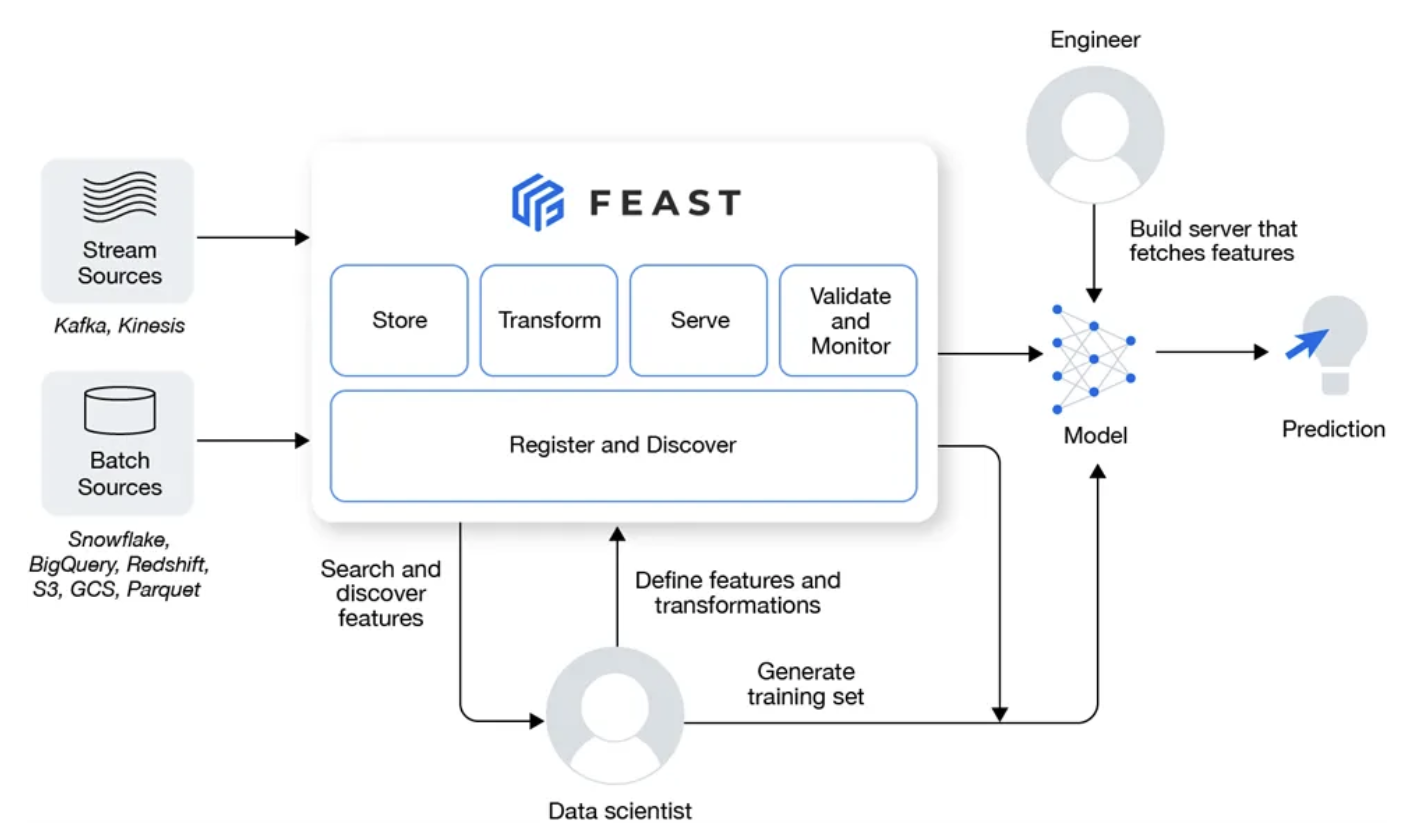

Feast를 사용하면 머신 러닝 및 데이터 과학 팀이 다음을 가능하게 합니다.

- 오프라인 또는 온라인 리포지토리에 피처를 저장합니다(오프라인 리포지토리와 온라인 리포지토리의 차이점은 나중에 자세히 설명합니다).  

- 트레이닝, 분석, 피처 엔지니어링을 위해 다양한 소스의 피처를 결합할 수 있습니다.  

- 추론을 위해 새로운 피처 데이터를 검색합니다.  

- 여러 프로젝트와 모델에서 피처를 재사용하세요.  

- 피처의 유효성을 검사하여 통계적 구성의 변화를 감지합니다(제한적으로 지원됨).  

Feast 버전 0.19.3부터 Feast 개발자는 경량 피처 엔지니어링 및 피처 검색에 대한 지원을 추가하고 피처 유효성 검사를 개선할 계획이었습니다.

feast의 역할은 다음과 다릅니다.

· An ETL (extract, transform, and load) or ELT (extract, load, and transform) system. Feast is not designed for general-purpose data transformation and pipelining.

· A data warehouse. Feast is not designed as a data warehouse solution or a source of truth for information.

· A data catalog. Feast is not designed for general-purpose data cataloging. It is specifically focused on features for machine learning.

### How does feast work

이 섹션에서는 Feast의 작동 방식과 인프라가 어떻게 구축되는지 설명합니다.

이해가 되지 않는 부분이 있어도 걱정하지 마세요. 이 섹션 이후에 코드에서 모든 것이 어떻게 작동하는지 보여드릴 테니까요. 이 가이드의 범위를 벗어나는 매우 구체적인 세부 사항이 포함된 Feast 문서를 꼭 확인하시기 바랍니다.

### Key concepts in Feast

Feast는 계층적 기능 저장소를 구현하여 기능을 저장하고 관리하는 데 도움을 줍니다. 버전 0.19.3부터 Feast 기능 저장소의 구조는 다음과 같습니다:

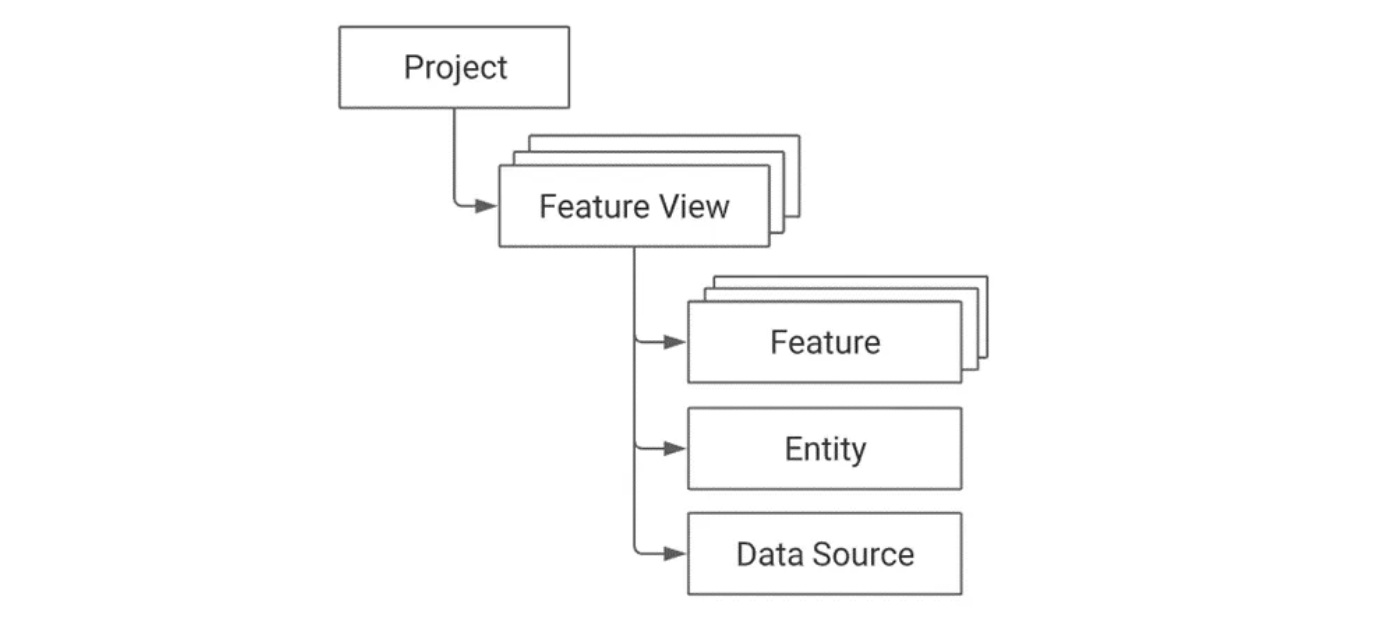

Feast 기능 리포지토리의 각 구성 요소의 의미는 다음과 같습니다:


- 프로젝트:  프로젝트는 관련 피처 및 해당 데이터 소스의 모음입니다. 프로젝트는 서로 분리되어 있으며, 한 프로젝트의 피처를 다른 프로젝트에서 재사용할 수 없습니다. 버전 0.19.3부터 프로젝트는 이전 버전의 Feast와의 하위 호환성을 보장하기 위해 지원되었습니다. Feast 개발자가 프레임워크를 단순화함에 따라 프로젝트의 개념이 변경될 수 있습니다.


- feature view: 특정 데이터 소스의 feature 데이터 그룹입니다. 피처 뷰를 사용하면 피처와 해당 데이터 소스를 일관되게 정의할 수 있으므로 프로젝트 전체에서 피처 그룹을 재사용할 수 있습니다. 피처가 둘 이상의 위치에 저장되어 있는 경우 각 위치에 대해 피처 뷰를 지정한 다음 나중에 모든 피처를 함께 조인할 수 있습니다. 피처뷰를 사용하면 기존 데이터에 새 기능을 매우 쉽게 추가할 수 있습니다. 새 피처 그룹을 수집할 때 해당 기능에 대한 별도의 기능 보기를 만든 다음 기존 데이터와 병합할 수 있습니다.


- 데이터 소스: Feast에서 각 피처뷰에는 데이터 소스가 있습니다. 데이터 소스는 원시 피처 데이터가 저장되는 곳으로, 로컬 .parquet 파일이나 GCP(Google Cloud Platform) 버킷과 같은 것입니다. 데이터 소스는 원하는 만큼 가질 수 있지만 서로 다른 유형의 소스를 함께 섞을 수는 없습니다.


- 피처 서비스: 피처 서비스는 하나 이상의 피처 뷰의 피처를 포함하는 개체입니다. 기능 서비스를 사용하여 논리적으로 관련된 기능 보기 그룹을 만들 수 있습니다.


- 엔티티: Feast 문서에서는 엔티티를 의미론적으로 관련된 피처의 모음으로 설명합니다. 실제로 엔티티는 피처 데이터와 관련된 개인이나 개체가 될 수 있습니다. 예를 들어 폐렴 데이터 세트가 있는 경우, 환자를 엔티티로 설정하고 식별을 위해 고유 ID를 할당할 수 있습니다. 그런 다음 ID를 사용하여 특정 피처 값을 저장하고 검색할 수 있습니다. Feast는 또한 엔티티를 사용하여 서로 다른 피처뷰의 데이터를 올바르게 조인합니다.


- 타임스탬프: Feast는 타임스탬프를 사용하여 서로 다른 소스의 피처가 올바른 시간 순서로 조인되도록 합니다. 이는 주로 훈련이나 예측에 아주 오래된 데이터를 사용하지 않도록 하기 위한 것입니다.


- 데이터 세트: 데이터 세트는 피처 뷰와 엔티티의 그룹입니다. Feast 데이터세트를 사용하면 엔지니어가 분석 및 학습을 위해 서로 다른 피처 뷰의 데이터를 결합할 수 있습니다.

### Feast infrastructure